# Exercise no. 4
In this exercise I am going do create model predicting number of passenger deaths using poisson distribution in two variatns.

In [1]:
import pystan
import stan_utility
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [104]:
data = pd.read_csv("input.csv", sep = ';')

## generation of vector for plotting samples under histograms
dths=[]
dths_cnt=[]
for k in data['Passenger deaths']:  
    dths_cnt.append(-(1.+dths.count(k)))
    dths.append(k)
dths_cnt=np.array(dths_cnt)

data

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown in 100 mln miles
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


# Task no. 1
In this task I assume that rate ($\lambda$) is constant for all years and independent on either year or miles flown.
I also assume that number of passengers deaths ($y_i$) has Poisson distribution:
$$y_i\sim\mathrm{Poisson}(\lambda)$$

For this task I need to assume that 10 people dying every day has very low probability (10*365=3650). Knowing that for poisson distribution $\lambda$ is mean and $\sqrt{\lambda}$ is standard deviation the following equasion have to be met:
$$\lambda+3\sqrt{\lambda}\approx3650$$
which means that probability is less than 1%.

In [5]:
root_of_lam=np.polynomial.polynomial.polyroots([-3650.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print("Calculated root: ")
print(lam_ub)

Calculated root: 
[3473.]


Using stan and algebra solver I want to find parameter ($\sigma$) of HalfNormal distributions that will fullify conditions I expect. 

In [6]:
with open('prior_HN.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess;
  vector[1] theta;
}

transformed data {
  vector[1] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}

//source: https://github.com/KAIR-ISZ


In [7]:
HN_model=stan_utility.compile_model('prior_HN.stan')
data=dict(y_guess=np.array([np.log(1000)]),theta=np.array(lam_ub))
HN_model_sampled = HN_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(HN_model_sampled.extract()['sigma'][0])
print("Calculated sigma parameter value: ")
print(sigma)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6ead991048da3250044766caa603606 NOW.


Calculated sigma parameter value: 
1348.0


Using calculated sigma value I'm drawing plot.

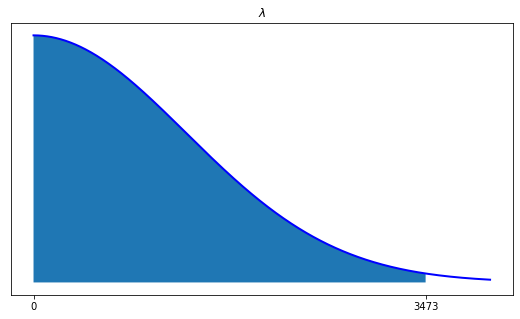

In [8]:
fig, ax2 = plt.subplots(1, 1,figsize=(9, 5))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color='blue',linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

Nom I'm going to use stan for simulating outputs basing only on input data - from previous years.

In [19]:
with open('prior_pred.stan', 'r') as file:
    print(file.read())

data {
  int M;
}

generated quantities {
  real lambda=fabs(normal_rng(0,1348));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

//source: https://github.com/KAIR-ISZ


In [20]:
pred_model=stan_utility.compile_model('prior_pred.stan')
R=1000
pred_model_sampled=pred_model.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)
params=pred_model_sampled.extract()
theta=params['lambda']
y_sim=params['y_sim']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce8674f17349b6eaa5837042c9dc7b6d NOW.


Using caluculated values I'm drawing 2 plots - histogram of lambda with HalfNormal line basing on sigma and histogram of predicted deaths.

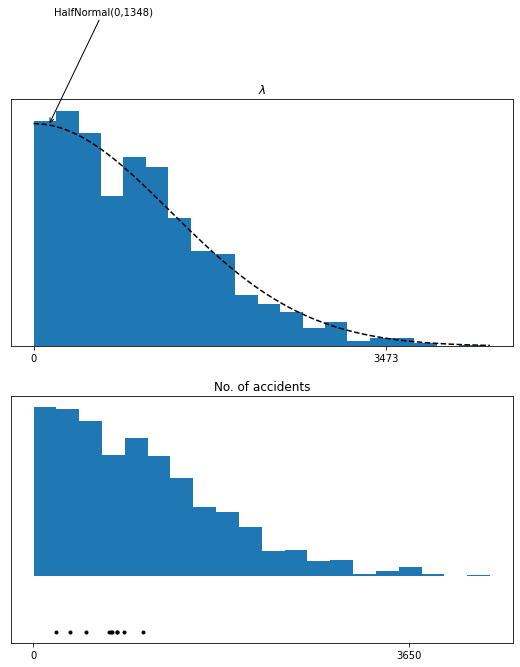

In [33]:
fig, axes = plt.subplots(2, 1,figsize=(9, 10))
ax1=axes[0]
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,4500,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(200,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(dths,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,3650])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

Now, I will do posterior predicitive checks and inference.

In [38]:
with open('checks_const.stan', 'r') as file:
    print(file.read())

data {
  int M;
  int y[M];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,121);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

//source: https://github.com/KAIR-ISZ


In [43]:
m_post=stan_utility.compile_model('checks_const.stan')
data = dict(M = len(data),
            y = data['Passenger deaths'])
fit = m_post.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

Using cached StanModel


In [45]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.95)
hpd_width=cinf_lam[1]-cinf_lam[0]

print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 688.80
89% confidence interval: [ 671.97 704.65 ]


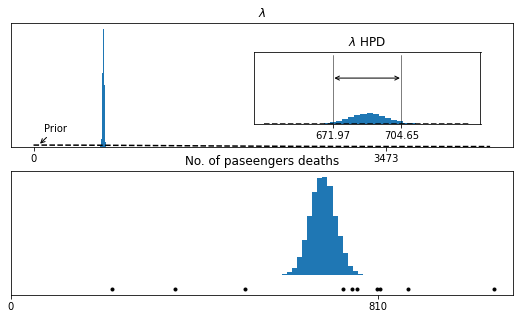

In [50]:
fig, axes = plt.subplots(2, 1,figsize=(9, 5))
ax1=axes[0]
ax1.hist(lam,bins=20,density=True)
x=np.linspace(0,4500,100)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(50,0,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),density=True,bins=20,zorder=1)
ax2.scatter(dths,0.002*dths_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of paseengers deaths')
plt.show()

Finally, I will predict number of deaths with created model, knowing that, there were 546 of them in 1986.

In [51]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.95)

print('Median of predicted deaths =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted deaths = 688.0
Confidence interval = [ 634.0 741.0 ]


As can be seen - model has predicted close but higher value.

# Task no. 2
In this task I assume that intensity ($\theta$) is constand but rate ($\lambda$) is product of intensity and miles flown ($\bar{n}$). I also assume that number of passengers deaths ($y_i$) has Poisson distribution:
$$y_i\sim\mathrm{Poisson}(\lambda)$$
 
For this task I need to assume that 10 people dying every day has very low probability (10*365=3650). This time we assume that $\lambda=\theta\cdot\bar{n}$. This gives us condition
$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx3650$$
 
which means that probability is less than 1%.

In [75]:
mean_miles=np.mean(data['Miles flown in 100 mln miles'])
root_of_theta=np.polynomial.polynomial.polyroots([-3650/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

data=dict(y_guess=np.array([np.log(0.1)]),theta=np.array(theta_ub))
HN_model_sampled = HN_model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (HN_model_sampled.extract()['sigma'][0])
print('Calculated sigma: ')
print('sigma =','{:4.3f}'.format(sigma))

theta upper bound 0.608
Calculated sigma: 
sigma = 0.236


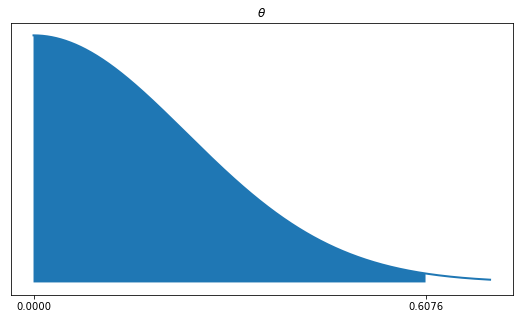

In [76]:
fig, ax2 = plt.subplots(1, 1,figsize=(9, 5))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_title(r'$\theta$')
plt.show()

Now, I will simulate outputs with stan using only prior data.

In [77]:
with open('prior_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}
generated quantities {
  real theta=fabs(normal_rng(0,0.236));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}

//source: https://github.com/KAIR-ISZ


In [83]:
model_prior=stan_utility.compile_model('prior_distance.stan')
R=1000
data_prior=dict(M=len(data),miles=data['Miles flown in 100 mln miles'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,seed=29042020)

Using cached StanModel


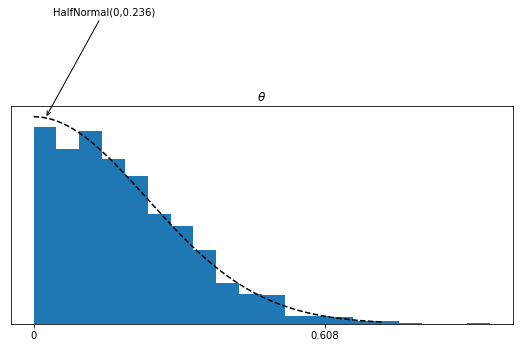

In [84]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(9, 4))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.025,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(0.025,arr_y_loc),xytext=(0.04,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

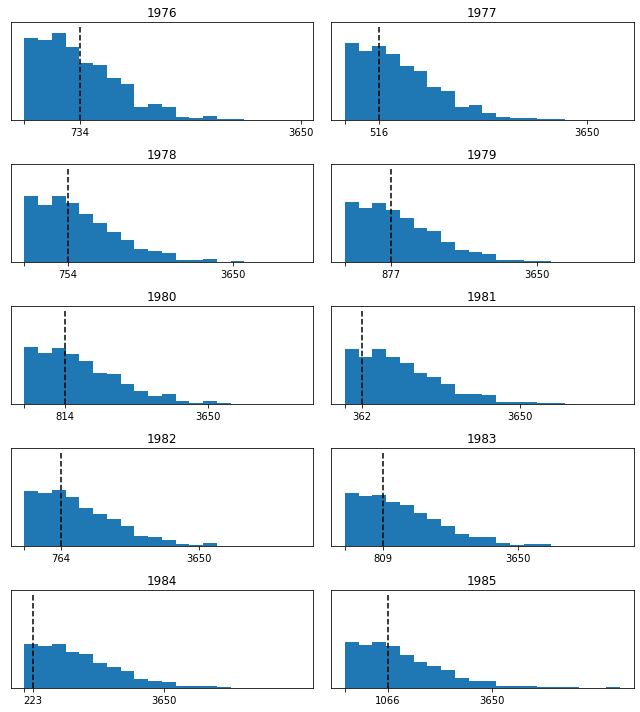

In [88]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(9, 10), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,density=True)
    ax.set_title(data['Year'][k])
    tv=data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.0009],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,3650])
    ax.set_xticklabels(['',tv,3650])

fig.tight_layout()

plt.show()

As before I will do posterior predicitive checks and inference.

In [89]:
with open('checks_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.021);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}


In [92]:
model_miles=stan_utility.compile_model('checks_distance.stan')
data = dict(M = len(data),
            miles = data['Miles flown in 100 mln miles'],
            y = data['Passenger deaths'])
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

Using cached StanModel


In [93]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.95)
hpd_width=cinf_theta[1]-cinf_theta[0]


print('Mean theta : {:5.4f}'.format(mean_theta))
print('95% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1205
95% confidence interval: [ 0.1178 0.1233 ]


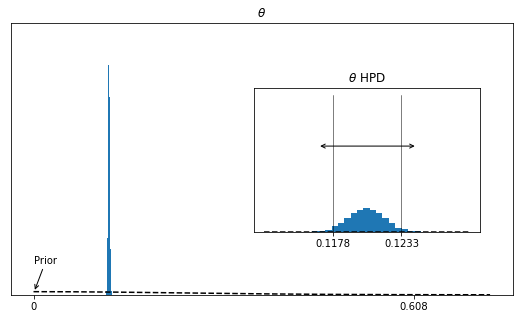

In [94]:
fig, axes = plt.subplots(1, 1,figsize=(9, 5))
ax1=axes
ax1.hist(theta,bins=20,density=True)
x=np.linspace(0,1.2*theta_ub[0],5000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(0.001,0,sigma)
ax1.annotate('Prior',xy=(0.001,arr_y_loc),xytext=(0.0015,10*arr_y_loc),arrowprops={'arrowstyle':'->'})

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(0.99*cinf_theta[0],1000), xytext=(1.01*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

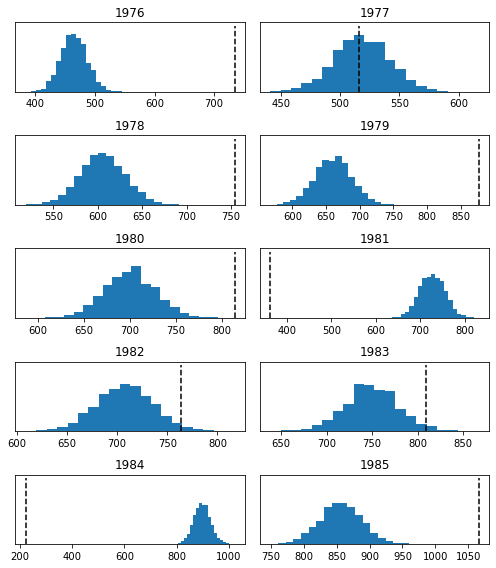

In [97]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,density=True)
    ax.set_title(data['Year'][k])
    tv=data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Finally, I will try to predict number of deaths in 1986. This time it is slightly more complicated as it requires modifying generated quantities block. There were 546 death and 0.06 death per 100 000 000 miles flown in 1986.

In [98]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [100]:
with open('prior_pred_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,0.236);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}


In [105]:
model1986=stan_utility.compile_model('prior_pred_distance.stan')

data = dict(M = len(data),
            miles = data['Miles flown in 100 mln miles'],
            y = data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)
y_1986=fit1986.extract()['y_1986']

median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.95)

print('Median of predicted deaths =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Using cached StanModel
Median of predicted deaths = 1102.0
Confidence interval = [ 1036.0 1169.0 ]


As can be seen - even though I have taken more data into consideration, result is worse than the one received in task no. 1. This time over two times bigger value has been predicted.